In [44]:
%matplotlib inline
import matplotlib_inline
import warnings
import csv

# matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')
warnings.filterwarnings('ignore')

import csv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import interp1d, interp2d
from scipy.special import *

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ["Computer Modern Roman"]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.markersize'] = 5

# Direct numerical simulation

Data

In [45]:
R = 1.5
H = 1
d = 0.015
eps = 0.22
mDot = 7.0

Thermophysical properties (from Van Lew, 2017)

In [46]:
# Fluid
rhof = 1733
muf = 0.0021
cpf = 1550
kf = 0.57

# Solid
rhos = 2640
cps = 1050
ks = 2.5

In [47]:
# velocidades
u = mDot/(eps*rhof*np.pi*R**2)
u0 = eps*u

In [48]:
dt = 2.5e-3
dx = 1e-2

t0 = 0
# Four times the experimental discharge time
tf = 1
xf = 1

t = np.arange(t0, tf + dt, dt)
x = np.arange(0, xf + dx, dx)

Nx = len(x) - 1
Nt = len(t) - 1

u = 1

In [49]:
CFL = dt*u/dx
print('CFL = ', CFL)
print('u = ', u)

CFL =  0.25
u =  1


In [50]:
# Reference temperatures
Tmin = 290 + 273
Tmax = 396 + 273

Tin = 1
T0 = 2*Tmin #Tmax

In [98]:
# Initialization
Tf = np.zeros((Nx+1, Nt+1))
Ts = np.zeros((Nx+1, Nt+1))

# BCs
Tf[0,:] = 0

# ICs
Tf[:,0] = 0
Ts[:,0] = 0

In [99]:
# Transport-term coeffs.
alpha = eps*rhof*cpf
gamma = (1 - eps)*rhos*cps

# Diffusive-term coeffs.
beta = eps*kf
betas = (1 - eps)*ks

In [100]:
# Calculation of heat transfer coeff.
Pr = cpf*muf/kf
rchar = eps*d/(4*(1-eps))
G = mDot/(eps*np.pi*R**2)
Re = 4*G*rchar/muf
h = 0.191*mDot*cpf/(eps*np.pi*R**2)*Re**(-0.278)*Pr**(-2/3)*np.pi*R**2


In [101]:
Lambda = h*H/(rhof*cpf*u*eps)
Lambdas = h*H/(rhos*cps*u*(1-eps))

Lambda = 50
Lambdas = 50

print(Lambda)
print(Lambdas)

50
50


In [102]:
# Matrix terms
p = u*dt/dx

q = beta/alpha*dt/(dx**2)
qs = betas*dt/(gamma*dx**2)

r = h*dt/alpha
rs = h*dt/gamma

##

kf = 0.01
ks = 0.01

p = u*dt/dx

q = kf*dt/(dx**2)
qs = ks*dt/(dx**2)

r = Lambda*dt
rs = Lambdas*dt

In [103]:
kf

0.01

In [104]:
# Explicit form of heat transfer term
diagonals = [np.ones(Nx)*(1 + 2*q + r + p), np.ones(Nx)*(-q), np.ones(Nx)*(-p-q)]

offsets = [0, 1, -1]
A = sp.sparse.diags(diagonals, offsets).toarray()
A[-1,-2] = -2*q - p
A[-1,-1] = 1 + 2*q + r + p + 2*q/p

A = sp.sparse.csr_matrix(A)

In [105]:
# Explicit form of heat transfer term
diagonals = [np.ones(Nx + 1)*(1 + 2*qs + rs), np.ones(Nx + 1)*(-qs), np.ones(Nx + 1)*(-qs)]

offsets = [0, 1, -1]
As = sp.sparse.diags(diagonals, offsets).toarray()
As[-1,-2] = -2*qs
As[0,1] = -2*qs

As = sp.sparse.csr_matrix(As)

In [106]:
bc0 = np.zeros(Nx)
bc1 = np.zeros(Nx)
Q = np.zeros(Nx+1)
Q[int(len(Q)/2)] = 1

bc0[0] = Tin
bc1[-1] = 1

In [107]:
AA = sp.sparse.block_diag((sp.sparse.linalg.inv(A), sp.sparse.linalg.inv(As)))

In [108]:
for i in range(1,Nt+1):
    
    bc1[-1] = 2*q/p*Tf[-1,i-1]
    TT = np.concatenate([Tf[1:Nx+1,i-1] + (q + p)*bc0 + r*Ts[1:,i-1] + bc1 + eps*dt*Q[1:],
                         Ts[:,i-1] + rs*Tf[:Nx+1,i-1] + eps*dt*Q*rhof*cpf/(rhos*cps)])
    
    sol = AA.dot(TT)
    
    Tf[1:Nx+1,i] = sol[:Nx]
    Ts[:,i] = sol[Nx:]
    

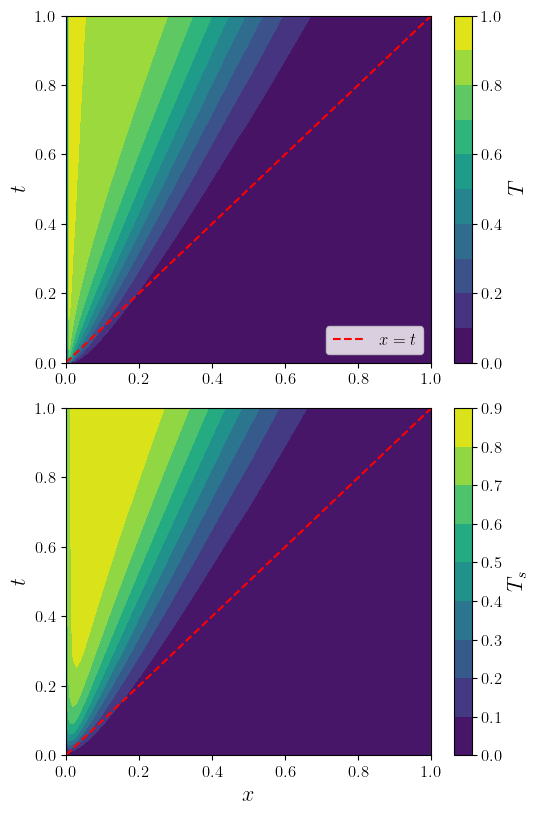

In [109]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex='row')
(ax1, ax2) = axs

ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=1)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=1)

thetaf = (Tf - Tin)/Tin
thetas = (Ts - Tin)/Tin

thetaf = Tf
thetas = Ts

cs1 = ax1.contourf(x/H, t*u/H, thetaf.T, 10)
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T$', fontsize=16)
ax1.set_ylabel(r'$t$', fontsize=16)
ax1.plot(x/H, x/H,'r--', label=r'$x = t$')

ax1.legend(loc='lower right')

cs2 = ax2.contourf(x/H, t*u/H, thetas.T, 10)
cbar2 = plt.colorbar(cs2)
cbar2.set_label(r'$T_s$', fontsize=16)
ax2.set_xlabel(r'$x$', fontsize=16)
ax2.set_ylabel(r'$t$', fontsize=16)
ax2.plot(x/H, x/H,'r--')
ax2.set_xlim([0, 1])

fig.savefig('./figs/DNS_T_vs_x_vs_t_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

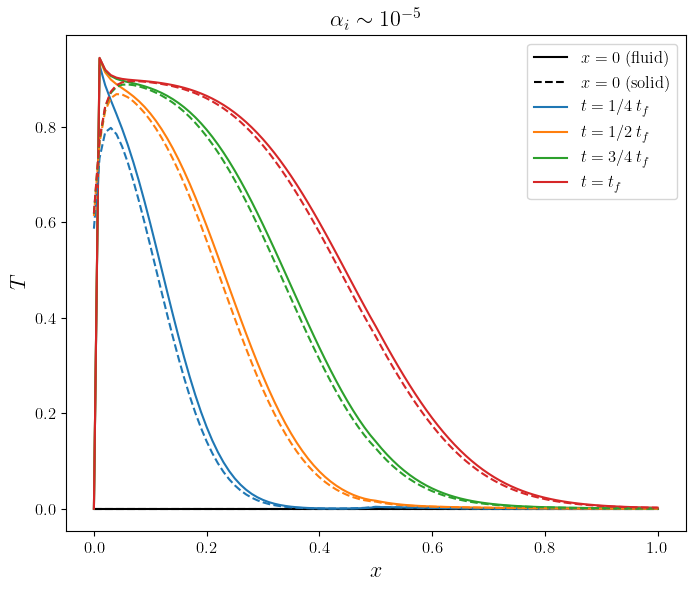

In [110]:
fig, ax = plt.subplots(figsize=(8,8))

plt.plot(x/H, thetaf[:,0], 'k', x/H, thetas[:,0], 'k--',
         x/H, thetaf[:,int(1/4*len(t))], 
         x/H, thetaf[:,int(2/4*len(t))], x/H, thetaf[:,int(3/4*len(t))], x/H, thetaf[:,-1])

plt.gca().set_prop_cycle(None)

plt.plot(x/H, thetas[:,int(1/4*len(t))], '--', 
         x/H, thetas[:,int(2/4*len(t))], '--', x/H, thetas[:,int(3/4*len(t))], '--',
         x/H, thetas[:,-1], '--')

plt.legend([r'$x = 0$ (fluid)', r'$x = 0$ (solid)', r'$t = 1/4 \,t_f$',
            r'$t = 1/2 \,t_f$', r'$t = 3/4 \,t_f$', r'$t = t_f$'])
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)
# ax.set_ylim([-1,0])

plt.title(r'$\alpha_i \sim 10^{-5}$', fontsize=16)

fig.savefig('./figs/DNS_Tf_Ts_vs_x_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(t*u/H, thetaf[int(1*len(x)/4),:], t*u/H, thetaf[int(2*len(x)/4),:], 
         t*u/H, thetaf[int(3*len(x)/4),:], t*u/H, thetaf[int(len(x)-1),:])

plt.gca().set_prop_cycle(None)

plt.plot(t*u/H, thetas[int(1*len(x)/4),:], '--',
         t*u/H, thetas[int(2*len(x)/4),:], '--', t*u/H, thetas[int(3*len(x)/4),:], '--',
         t*u/H, thetas[-1,:], '--')

plt.legend([r'$x = 0$ (fluid)', r'$x = 0$ (solid)', r'$x = 1/4$',
            r'$x = 1/2$', r'$x = 3/4$', r'$x = 1$'])
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$t$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)
# ax.set_ylim([-0.3,0.1])

plt.title(r'$\alpha_i \sim 10^{-5}$', fontsize=16)

fig.savefig('./figs/DNS_Tf_Ts_vs_t_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

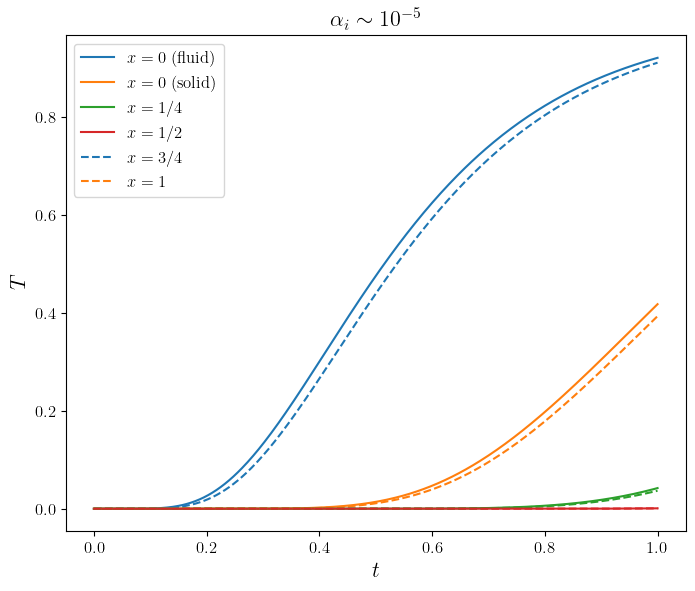

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(t*u/H, thetaf[int(1*len(x)/4),:], t*u/H, thetaf[int(2*len(x)/4),:], 
         t*u/H, thetaf[int(3*len(x)/4),:], t*u/H, thetaf[-1,:])

plt.gca().set_prop_cycle(None)

plt.plot(t*u/H, thetas[int(1*len(x)/4),:], '--',
         t*u/H, thetas[int(2*len(x)/4),:], '--', t*u/H, thetas[int(3*len(x)/4),:], '--',
         t*u/H, thetas[-1,:], '--')

plt.legend([r'$x = 0$ (fluid)', r'$x = 0$ (solid)', r'$x = 1/4$',
            r'$x = 1/2$', r'$x = 3/4$', r'$x = 1$'])
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$t$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)

plt.title(r'$\alpha_i \sim 10^{-5}$', fontsize=16)

fig.savefig('./figs/DNS_Tf_Ts_vs_t_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

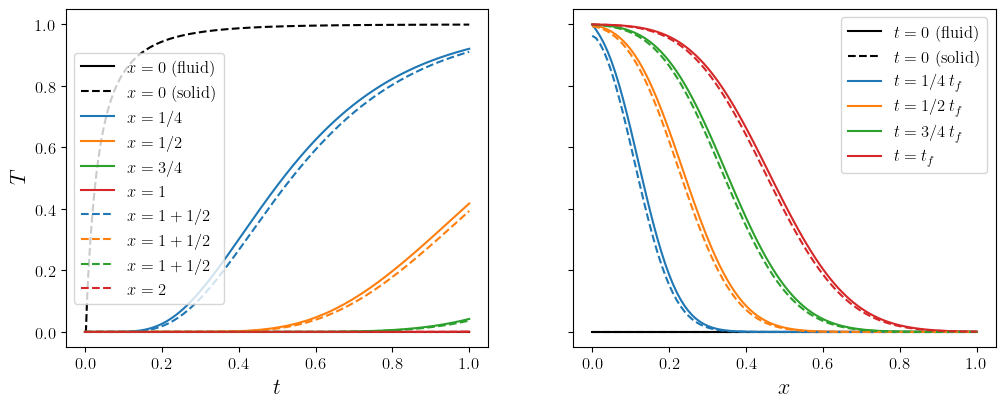

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,12), sharey='all')
(ax1, ax2) = axs

ax1.plot(t*u/H, thetaf[0,:]*0, 'k-', t*u/H, thetas[0,:], 'k--',
         t*u/H, thetaf[int(1/4*len(x)),:],
         t*u/H, thetaf[int(1/2*len(x)),:],
         t*u/H, thetaf[int(3/4*len(x)),:],
         t*u/H, thetaf[-1,:])

ax1.set_prop_cycle(None)

ax1.plot(t*u/H, thetas[int(1/4*len(x)),:], '--',
         t*u/H, thetas[int(1/2*len(x)),:], '--',
         t*u/H, thetas[int(3/4*len(x)),:], '--',
         t*u/H, thetas[-1,:], '--')

ax1.legend([r'$x = 0$ (fluid)', r'$x = 0$ (solid)', r'$x = 1/4$', r'$x = 1/2$', r'$x = 3/4$', r'$x = 1$',
            r'$x = 1 + 1/2$', r'$x = 1 + 1/2$', r'$x = 1 + 1/2$', r'$x = 2$'])
ax1.set_box_aspect(0.8)
ax1.set_xlabel(r'$t$', fontsize=16)
ax1.set_ylabel(r'$T$', fontsize=16)

##

ax2.plot(x/H, thetaf[:,0], 'k', x/H, thetas[:,0], 'k--', x/H, thetaf[:,int(1/4*len(t))], 
         x/H, thetaf[:,int(2/4*len(t))], x/H, thetaf[:,int(3/4*len(t))], x/H, thetaf[:,-1])

plt.gca().set_prop_cycle(None)

ax2.plot(x/H, thetas[:,int(1/4*len(t))], '--', 
         x/H, thetas[:,int(2/4*len(t))], '--',
         x/H, thetas[:,int(3/4*len(t))], '--',
         x/H, thetas[:,-1], '--')

ax2.legend([r'$t = 0$ (fluid)', r'$t = 0$ (solid)', r'$t = 1/4 \,t_f$', r'$t = 1/2 \,t_f$', r'$t = 3/4 \,t_f$', r'$t = t_f$'])
ax2.set_box_aspect(0.8)
ax2.set_xlabel(r'$x$', fontsize=16)


fig.savefig('./figs/DNS_T_vs_x_vs_t_subplot_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

# Method of Characteristics for extended nonporous domain

In [24]:
print(Lambda)
print(Lambdas)

50
50


In [25]:
# Malla características
CFL = dt*u/dx

dtc = dt*u/H
dxc = dtc

xc = np.arange(0, 1 + dxc, dxc)
tc = np.arange(0, tf*u/H + dtc, dtc)

In [26]:
# Discretización
xvc, tvc = np.meshgrid(xc, tc, indexing='ij')

Cp = xvc*0
Cn = xvc*0

Tsc = xvc*0 + 1
Tfc = xvc*0 + 1

# ICs
Tfc[:,0] = 0
Tsc[:,0] = 0

# BCs
Tfc[0,:] = 1 #(Tin - T0)/T0

# Valor inicial de las características
Cp[:,0] = tc[0] + xc
Cn[:,0] = xc

Matrix assembly

In [27]:
A = [[1 + 0.5*Lambda*dtc, -0.5*Lambda*dtc],
    [-0.5*Lambdas*dtc, 1 + 0.5*Lambdas*dtc]]
Ainv = np.linalg.inv(A)

In [28]:
# Numerical integration by using explicit Euler
for j in range(1,len(tc)): 
    Cp[:,j] = tc[j] + xc
    Cn[:,j] = xc

    for i in range(1,len(xc)):
        
        Tfc[i,j], Tsc[i-1,j] = Ainv.dot([-0.5*Lambda*(Tfc[i-1,j-1] - Tsc[i-1,j-1])*dtc + Tfc[i-1,j-1],
                                        0.5*Lambdas*(Tfc[i-1,j-1] - Tsc[i-1,j-1])*dtc + Tsc[i-1,j-1]])
        

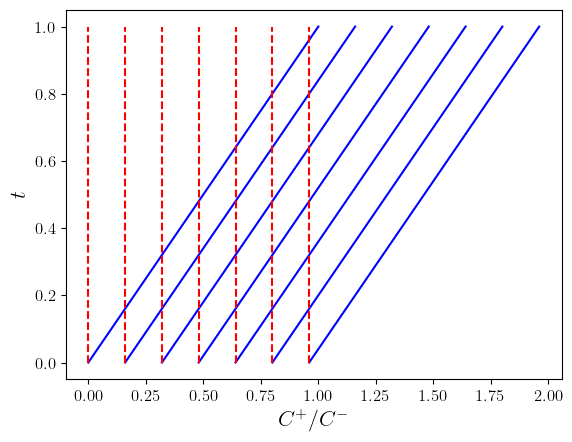

In [29]:
fig, axs = plt.subplots()

axs.plot(Cp[::64,:].T, tc, 'b-')
axs.plot(Cn[::64,:].T, tc, 'r--')

axs.set_ylabel(r'$t$', fontsize=16)
axs.set_xlabel(r'$C^+/C^-$', fontsize=16)

fig.savefig('./figs/characteristics_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

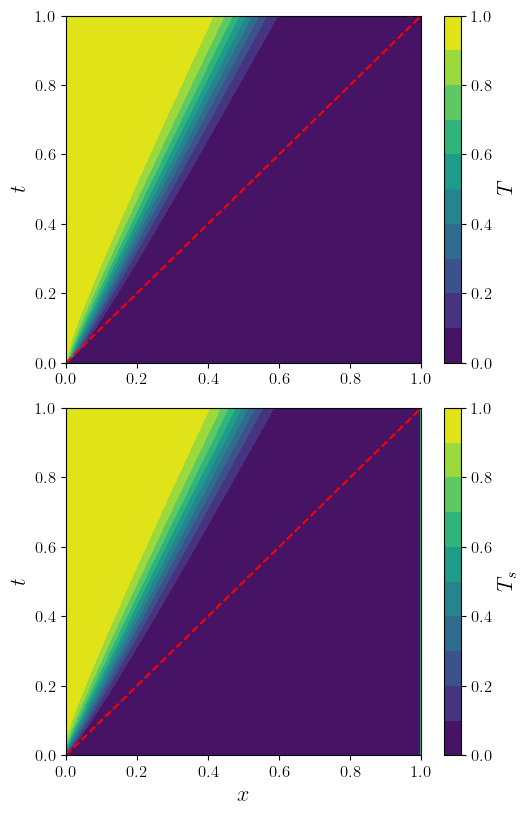

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex='row')
(ax1, ax2) = axs

ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=1)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=1)

cs1 = ax1.contourf(xvc, tvc, Tfc, 10)
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T$', fontsize=16)
ax1.set_ylabel(r'$t$', fontsize=16)
ax1.plot(xc, xc,'r--', label=r'$x = t$')


cs2 = ax2.contourf(xvc, tvc, Tsc, 10)
plt.tight_layout()
cbar2 = plt.colorbar(cs2)
cbar2.set_label(r'$T_s$', fontsize=16)
ax2.set_ylabel(r'$t$', fontsize=16)
# ax2.set_box_aspect(1)
ax2.plot(xc, xc,'r--', label=r'$x = t$')
ax2.set_xlim([0, 1])
#ax2.set_ylim([0, 1])
ax2.set_xlabel(r'$x$', fontsize=16)

fig.savefig('./figs/char_T_vs_x_vs_t_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

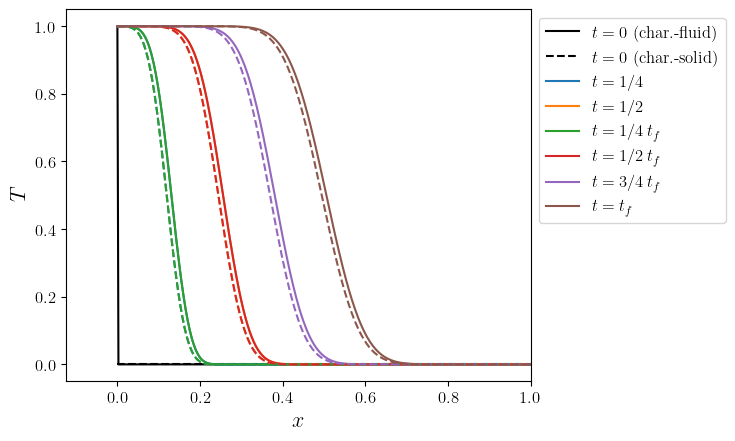

In [31]:
fig, ax = plt.subplots(figsize=(6,8))

plt.plot(xc, Tfc[:,0], 'k-', xc, Tsc[:,0], 'k--',
         xc, Tfc[:,int(0.25/dtc)], xc, Tfc[:,int(0.5/dtc)],
         xc, Tfc[:,int(1/4*len(tc))], xc, Tfc[:,int(2/4*len(tc))],
         xc, Tfc[:,int(3/4*len(tc))], xc, Tfc[:,-1])

plt.gca().set_prop_cycle(None)

plt.plot(xc[:-1], Tsc[:-1,int(0.25/dtc)], '--', xc[:-1], Tsc[:-1,int(0.5/dtc)], '--',
         xc[:-1], Tsc[:-1,int(1/4*len(tc))], '--', xc[:-1], Tsc[:-1,int(2/4*len(tc))], '--',
         xc[:-1], Tsc[:-1,int(3/4*len(tc))], '--', xc[:-1], Tsc[:-1,-1], '--')

plt.xlim([-0.125, xc[-1]])

plt.legend([r'$t = 0$ (char.-fluid)', r'$t = 0$ (char.-solid)',
            r'$t = 1/4$',r'$t = 1/2$',r'$t = 1/4 \,t_f$',
            r'$t = 1/2 \,t_f$', r'$t = 3/4 \,t_f$', r'$t = t_f$'], bbox_to_anchor=(1, 1), loc='upper left')
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)
fig.savefig('./figs/char_Tf_Ts_vs_x_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

# Profiles comparison: DNS vs. characteristics for nonporous extended domain

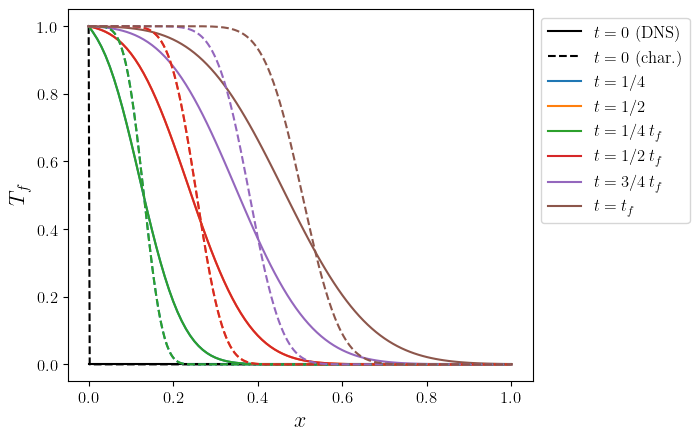

In [32]:
fig, ax = plt.subplots(figsize=(6,8))

plt.plot(x/H, thetaf[:,0], 'k',
         xc, Tfc[:,0], 'k--',
         x/H, thetaf[:,int(0.25*H/u/dt)],
         x/H, thetaf[:,int(0.50*H/u/dt)],
         x/H, thetaf[:,int(1/4*len(t))],
         x/H, thetaf[:,int(2/4*len(t))],
         x/H, thetaf[:,int(3/4*len(t))],
         x/H, thetaf[:,-1])

plt.gca().set_prop_cycle(None)

plt.plot(xc[:-1], Tfc[:-1,int(0.25/dtc)], '--',
         xc[:-1], Tfc[:-1,int(0.50/dtc)], '--',
         xc[:-1], Tfc[:-1,int(1/4*len(tc))], '--',
         xc[:-1], Tfc[:-1,int(2/4*len(tc))], '--',
         xc[:-1], Tfc[:-1,int(3/4*len(tc))], '--',
         xc[:-1], Tfc[:-1,-1], '--')


plt.legend([r'$t = 0$ (DNS)', r'$t = 0$ (char.)',
            r'$t = 1/4$', r'$t = 1/2$',
            r'$t = 1/4 \,t_f$', r'$t = 1/2 \,t_f$',
            r'$t = 3/4 \,t_f$', r'$t = t_f$'], bbox_to_anchor=(1, 1), loc='upper left')
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T_f$', fontsize=16)
fig.savefig('./figs/DNS_vs_characteristics_fluid_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

In [33]:
# Interpolation
f = interp2d(x, t, thetaf.T, kind='linear')
g = interp2d(x, t, thetas.T, kind='linear')
thetafq = f(xc*H, t)
thetasq = g(xc*H, t)

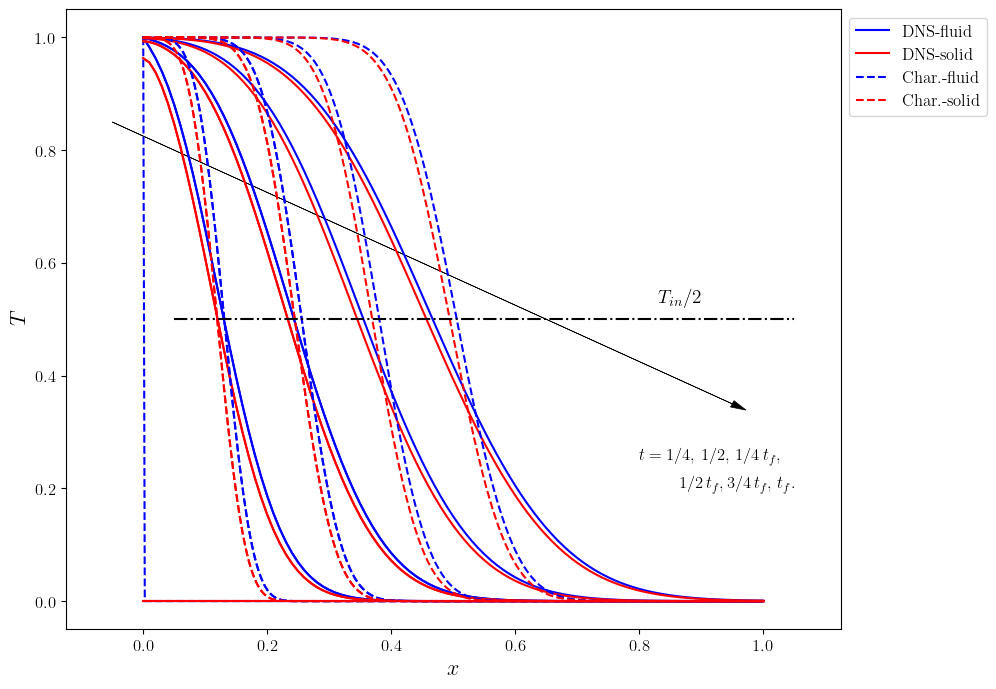

In [34]:
fig, ax = plt.subplots(figsize=(10,10))

# DNS - fluid
plt.plot(x/H, thetaf[:,0], 'b-')
plt.plot(xc, Tfc[:,0], 'b--')
plt.plot(x/H, thetas[:,0], 'r-')
plt.plot(xc[:-1], Tsc[:-1,0], 'r--')

plt.plot(x/H, thetaf[:,int(0.25*H/u/dt)], 'b-', label='DNS-fluid')
plt.plot(x/H, thetaf[:,int(0.50*H/u/dt)], 'b-')
plt.plot(x/H, thetaf[:,int(1/4*len(t))], 'b-')
plt.plot(x/H, thetaf[:,int(2/4*len(t))], 'b-')
plt.plot(x/H, thetaf[:,int(3/4*len(t))], 'b-')
plt.plot(x/H, thetaf[:,-1], 'b-')

# DNS - solid
plt.plot(x/H, thetas[:,int(0.25*H/u/dt)], 'r-')
plt.plot(x/H, thetas[:,int(0.50*H/u/dt)], 'r-')
plt.plot(x/H, thetas[:,int(1/4*len(t))], 'r-', label='DNS-solid')
plt.plot(x/H, thetas[:,int(2/4*len(t))], 'r-')
plt.plot(x/H, thetas[:,int(3/4*len(t))], 'r-')
plt.plot(x/H, thetas[:,-1], 'r-')

# Char. - fluid
plt.plot(xc[:-1], Tfc[:-1,int(0.25/dtc)], 'b--')
plt.plot(xc[:-1], Tfc[:-1,int(0.50/dtc)], 'b--')
plt.plot(xc[:-1], Tfc[:-1,int(1/4*len(tc))], 'b--', label='Char.-fluid')
plt.plot(xc[:-1], Tfc[:-1,int(2/4*len(tc))], 'b--')
plt.plot(xc[:-1], Tfc[:-1,int(3/4*len(tc))], 'b--')
plt.plot(xc[:-1], Tfc[:-1,-1], 'b--')

# Char. - solid
plt.plot(xc[:-1], Tsc[:-1,int(0.25/dtc)], 'r--')
plt.plot(xc[:-1], Tsc[:-1,int(0.50/dtc)], 'r--')
plt.plot(xc[:-1], Tsc[:-1,int(1/4*len(tc))], 'r--', label='Char.-solid')
plt.plot(xc[:-1], Tsc[:-1,int(2/4*len(tc))], 'r--')
plt.plot(xc[:-1], Tsc[:-1,int(3/4*len(tc))], 'r--')
plt.plot(xc[:-1], Tsc[:-1,-1], 'r--')

# Average T
plt.plot(xc + 0.05, xc*0 + 0.5, 'k-.')

# Cosmetics
plt.text(0.83, 0.53, r'$T_{in}/2$', fontsize=14)
plt.arrow(-0.05, 0.85, 1, -0.5, width=0.0001, color='k', head_width=0.0125, head_length=0.025, lw=0.5)
plt.text(0.80, 0.25, r'$t = 1/4,\, 1/2,\,1/4\,t_f,$', fontsize=12) 
plt.text(0.865, 0.20, r'$1/2\,t_f,3/4\,t_f,\,t_f.$', fontsize=12)

plt.xlim([-0.125, xc[-1] + 0.125])

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)

fig.savefig('./figs/DNS_vs_characteristics_all_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '.pdf', bbox_inches='tight')
plt.show()
